# Library

In [1]:
import pandas as pd

from src.utils import print_h, check_dataset_info, plot_anomaly_detection, plot_anomaly_detection_GaJuSi
from src.data import Dataset_v2

# Config

In [2]:
workspace = 'local' # local | remote | colab

if workspace == 'remote':
    data_dir = '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/datasets'
    vgrf_data_dir = data_dir + '/physionet-pd-dataset'
else:
    data_dir = 'data'
    vgrf_data_dir = data_dir + '/gait-in-parkinsons-disease-1.0.0'
demographics_data_path = vgrf_data_dir + '/demographics.xls'

n_feat = 16
window_size = 500
stride_size = 500
min_vgrf_data_len = 0
max_vgrf_data_len = 25_000
test_person_split = 0.15
test_window_split = 0.15

# Data

## Data Loading

In [9]:
# demographics_df = pd.read_csv(demographics_data_path)
demographics_df = pd.read_excel(demographics_data_path)
demographics_df['HoehnYahr'] = demographics_df['HoehnYahr'].fillna(0)   # Fill N/A values in 'HoehnYahr' column
demographics_df['Weight (kg)'] = demographics_df['Weight (kg)'].fillna(demographics_df['Weight (kg)'].mean())
demographics_df['Height (meters)'] = demographics_df['Height (meters)'].fillna(demographics_df['Height (meters)'].mean())

def compute_bmi(row):
    return row['Weight (kg)'] / (row['Height (meters)'] ** 2)

demographics_df['BMI'] = demographics_df.apply(compute_bmi, axis=1)

dataset_person = Dataset_v2(demographics_df, vgrf_data_dir, n_feat, 
                            min_vgrf_data_len, max_vgrf_data_len, window_size, stride_size, 
                            type='person')

check_dataset_info(dataset_person.X, dataset_person.y)

## Anomaly Detection

In [4]:
# plot_anomaly_detection(dataset_person, dataset_study='Ga', outlier_thresh=(None, None))

In [5]:
# plot_anomaly_detection(dataset_person, dataset_study='Ju', outlier_thresh=(-25, None))

In [6]:
# plot_anomaly_detection(dataset_person, dataset_study='Si', outlier_thresh=(40, None))

Dataset - Ga anomaly data: []
Dataset - Ju anomaly data: ['JuPt18']
Dataset - Si anomaly data: ['SiPt08', 'SiPt09']


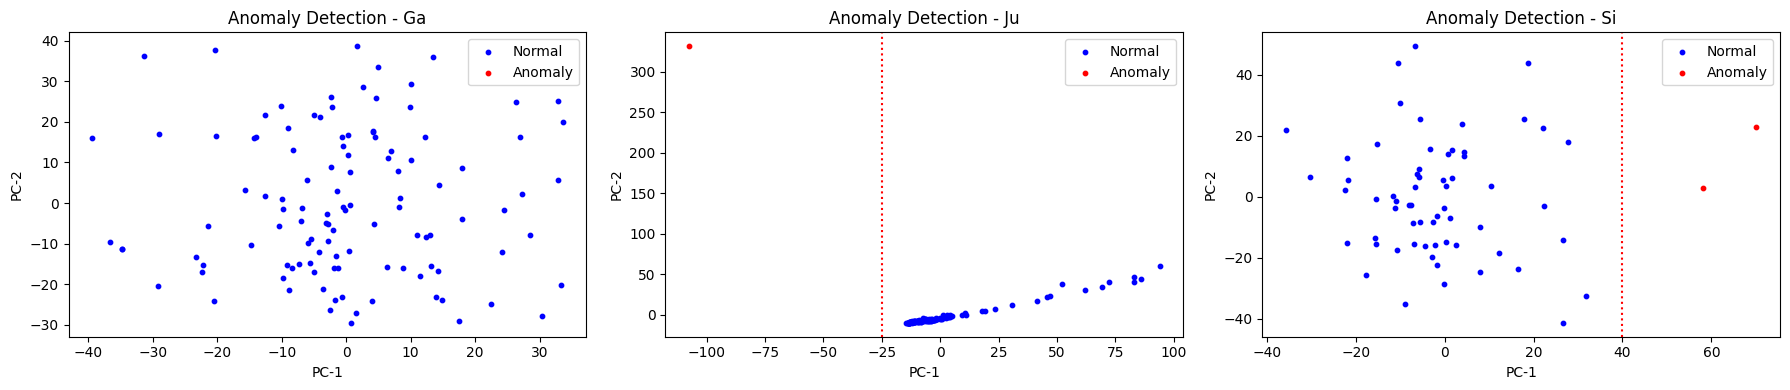

Saved in: anomaly_detection


In [7]:
plot_anomaly_detection_GaJuSi(dataset_person, outlier_thresh_map={
    'Ga': (None, None),
    'Ju': (-25, None),
    'Si': (40, None),
})